## Para muestra random de preguntas

In [ ]:
import random

preguntas = [q for q in quiz_preguntas if q["nivel"] == nivel]
muestra = random.sample(preguntas, k=min(2, len(preguntas)))

# Implementar nodo inicial 

In [1]:
from langgraph.graph import StateGraph, END
from pydantic import BaseModel
from typing import List, Optional
import random
from IPython.display import Image, display

# 1. Definir el esquema del estado
class Estado(BaseModel):
    modo: Optional[str] = None
    nivel: Optional[str] = None
    temas: Optional[List[str]] = []
    tema_actual: Optional[int] = 0
    ultima_pregunta: Optional[str] = None  
    aprobo_repaso: Optional[bool] = None

# 2. Preguntas de ejemplo para el quiz de nivel
quiz_preguntas = [
    {"pregunta": "¿Qué es una variable aleatoria?", "nivel": "basico"},
    {"pregunta": "¿Qué es la desviación estándar?", "nivel": "intermedio"},
    {"pregunta": "¿Cómo se calcula la probabilidad conjunta de dos eventos independientes?", "nivel": "avanzado"},
]

# 3. Temas por nivel
temas_por_nivel = {
    "basico": ["Conceptos básicos de probabilidad", "Variables aleatorias", "Distribuciones simples"],
    "intermedio": ["Estadística descriptiva", "Medidas de dispersión", "Desviación estándar"],
    "avanzado": ["Probabilidad conjunta", "Teorema de Bayes", "Distribuciones avanzadas"]
}

# 4. Nodos del grafo
def nodo_inicio(state: Estado) -> Estado:
    respuesta = input("¿Quieres aprender de forma guiada o prefieres hacer preguntas libres? (guiado/libre): ")
    state.modo = respuesta.strip().lower()
    return state

def nodo_quiz_nivel(state: Estado) -> Estado:
    print("\nVamos a hacer un quiz para conocer tu nivel.")
    puntaje = 0
    for q in quiz_preguntas:
        resp = input(q["pregunta"] + " (responde brevemente): ")
        # Aquí podrías poner lógica para evaluar la respuesta, por ahora sumamos 1 por cada respuesta
        puntaje += 1  # Simulación
    # Lógica simple para determinar el nivel
    if puntaje <= 1:
        nivel = "basico"
    elif puntaje == 2:
        nivel = "intermedio"
    else:
        nivel = "avanzado"
    state.nivel = nivel
    return state

def nodo_plan_estudio(state: Estado) -> Estado:
    nivel = state.nivel
    print(f"\nTu nivel es: {nivel}. Estos son los temas que vamos a estudiar:")
    for tema in temas_por_nivel[nivel]:
        print("-", tema)
    state.temas = temas_por_nivel[nivel]
    state.tema_actual = 0  # Empezamos por el primer tema
    return state

def nodo_explicar_tema(state: Estado) -> Estado:
    temas = state.temas
    idx = state.tema_actual
    if idx < len(temas):
        print(f"\nExplicando tema: {temas[idx]}")
        # Aquí luego se integrará RAG para explicar el tema
        return state
    else:
        print("\n¡Terminaste todos los temas de este nivel!")
        return state

def nodo_preguntas_tema(state: Estado) -> Estado:
    pregunta = input("\n¿Tienes alguna duda sobre este tema? (escribe tu pregunta o 'no' para continuar): ")
    state.ultima_pregunta = pregunta.strip().lower()
    if state.ultima_pregunta in ["no", "ninguna", "no tengo dudas"]:
        state.tema_actual += 1  # Avanza al siguiente tema solo si no hay dudas
    else:
        print("Respuesta del agente: (Aquí irá la respuesta usando RAG en el futuro)")
    return state


def nodo_quiz_repaso(state: Estado) -> Estado:
    nivel = state.nivel
    print(f"\nQuiz de repaso para el nivel {nivel}.")
    preguntas = [q for q in quiz_preguntas if q["nivel"] == nivel]
    # Si solo hay una pregunta, la toma; si hay más, puedes tomar una muestra aleatoria si quieres
    muestra = random.sample(preguntas, k=1) if len(preguntas) > 0 else []
    puntaje = 0
    for q in muestra:
        resp = input(q["pregunta"] + " (responde brevemente): ")
        # Simulación de corrección: pregunta al usuario si cree que respondió bien
        correcto = input("¿Respondiste correctamente? (si/no): ").strip().lower()
        if correcto == "si":
            puntaje += 1
    # Si contestó bien la(s) pregunta(s), aprueba
    if puntaje == len(muestra) and len(muestra) > 0:
        print("¡Felicidades, aprobaste el quiz de repaso!")
        state.aprobo_repaso = True
    else:
        print("No aprobaste el quiz de repaso. Repasaremos los temas.")
        state.aprobo_repaso = False
    return state

def nodo_libre(state: Estado) -> Estado:
    print("\nHas elegido preguntas libres. Aquí puedes preguntar lo que quieras...")
    return state

# 5. Crear el grafo de estados
graph = StateGraph(Estado)

# 6. Añadir nodos
graph.add_node("inicio", nodo_inicio)
graph.add_node("quiz_nivel", nodo_quiz_nivel)
graph.add_node("plan_estudio", nodo_plan_estudio)
graph.add_node("explicar_tema", nodo_explicar_tema)
graph.add_node("preguntas_tema", nodo_preguntas_tema)
graph.add_node("quiz_repaso", nodo_quiz_repaso)
graph.add_node("libre", nodo_libre)

# 7. Definir transiciones
def transicion_inicio(state: Estado):
    if state.modo == "si":
        return "quiz_nivel"
    else:
        return "libre"

def transicion_quiz_nivel(state: Estado):
    return "plan_estudio"

def transicion_plan_estudio(state: Estado):
    return "explicar_tema"

def transicion_explicar_tema(state: Estado):
    return "preguntas_tema"

def transicion_preguntas_tema(state: Estado):
    temas = state.temas
    idx = state.tema_actual
    if idx < len(temas):
        return "explicar_tema"
    else:
        return "quiz_repaso"

def transicion_quiz_repaso(state: Estado):
    niveles = ["basico", "intermedio", "avanzado"]
    idx_nivel = niveles.index(state.nivel)
    if state.aprobo_repaso:
        if idx_nivel + 1 < len(niveles):
            # Avanza al siguiente nivel
            state.nivel = niveles[idx_nivel + 1]
            state.temas = temas_por_nivel[state.nivel]
            state.tema_actual = 0
            return "plan_estudio"
        else:
            print("\n¡Felicidades, completaste todos los niveles! Ahora puedes hacer preguntas libres.")
            return "libre"
    else:
        # Repite el mismo nivel
        state.tema_actual = 0
        return "plan_estudio"

# 8. Agregar transiciones al grafo
graph.add_conditional_edges("inicio", transicion_inicio, path_map={"quiz_nivel": "quiz_nivel", "libre": "libre"})
graph.add_edge("quiz_nivel", "plan_estudio")
graph.add_edge("plan_estudio", "explicar_tema")
graph.add_edge("explicar_tema", "preguntas_tema")
graph.add_conditional_edges("preguntas_tema", transicion_preguntas_tema, path_map={"explicar_tema": "explicar_tema", "quiz_repaso": "quiz_repaso"})
graph.add_conditional_edges("quiz_repaso", transicion_quiz_repaso, path_map={"plan_estudio": "plan_estudio", "libre": "libre"})
graph.add_edge("libre", END)

# 9. Definir el nodo inicial y compilar
graph.set_entry_point("inicio")
app = graph.compile()

# 10. Ejecutar el grafo
state = Estado()

In [3]:
app.invoke(state)


Has elegido preguntas libres. Aquí puedes preguntar lo que quieras...


{'modo': 'no', 'temas': [], 'tema_actual': 0}

In [5]:
app.stream(state)

<generator object Pregel.stream at 0x0000020DBE19D540>

In [6]:
imagen = app.get_graph().draw_mermaid_png()

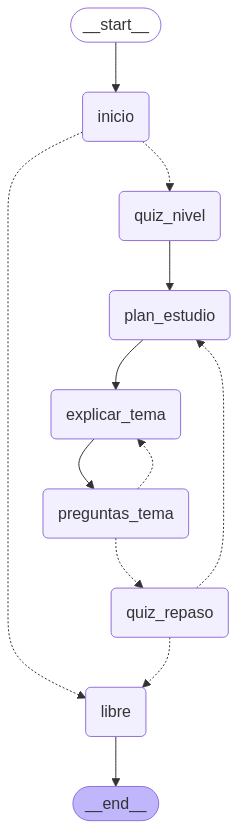

In [7]:
display(Image(imagen))

In [4]:
!pip install pipreqs

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
   ---------------------------------------- 0.0/798.3 kB ? eta -:--:--
   --------------------------------------- 798.3/798.3 kB 17.3 MB/s eta 0:00:00
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13822 sha

In [13]:
!pipreqs . 

INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in .\requirements.txt


In [8]:
!pipreqs . --ignore-errors --encoding=utf8 --mode=no-pin --include-ipynb

Usage:
    pipreqs [options] [<path>]


In [9]:
!pipreqs . --ignore-errors --encoding=utf8 --mode=no-pin --include-ipynb --force --savepath ./requirements.txt

Usage:
    pipreqs [options] [<path>]
